<a href="https://colab.research.google.com/github/EllouziMedAmin/DSWithPytorch/blob/main/HE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###download dataset

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download muhammadhananasghar/human-emotions-datasethes

In [ ]:
!unzip human-emotions-datasethes.zip
!rm -rf human-emotions-datasethes.zip

In [ ]:
!rm -r /content/EmotionsDataset_Splitted
!rm -r /content/EmotionsDataset

###preprocessing

In [6]:
import tensorflow as tf

In [7]:
TRAIN_DIR='/content/Data/Emotions Dataset/train'
TEST_DIR='/content/Data/Emotions Dataset/test'
CLASS_NAMES =['angry','happy','sad']

####configuration

In [50]:
CONFIGURATIONS={
    'BATCH_SIZE':32,
    'IMAGE_SIZE':256,
    'CHANNELS':3,
    'LEARNING_RATE':1e-3,
    'N_EPOCHS':20,
    'N_CLASSES':3,
    'DROPOUT_RATE':0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE':3,
    'N_STRIDES':1,
    'N_DENSE_UNITS_1':1024,
    'N_DENSE_UNITS_2':128,
    'POOL_SIZE':2



}


####preparing dataset

In [33]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATIONS['BATCH_SIZE'],
    image_size=(CONFIGURATIONS['IMAGE_SIZE'], CONFIGURATIONS['IMAGE_SIZE']),
    shuffle=True,
    seed=1,

)

Found 6799 files belonging to 3 classes.


In [34]:
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATIONS['BATCH_SIZE'],
    image_size=(CONFIGURATIONS['IMAGE_SIZE'], CONFIGURATIONS['IMAGE_SIZE']),
    shuffle=True,
    seed=1,

)

Found 2278 files belonging to 3 classes.


In [21]:
for X,y in train_data.take(1):
  print(X.shape)
  print(y.shape)
  print(y)


(32, 256, 256, 3)
(32, 3)
tf.Tensor(
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]], shape=(32, 3), dtype=float32)


####data visualisation

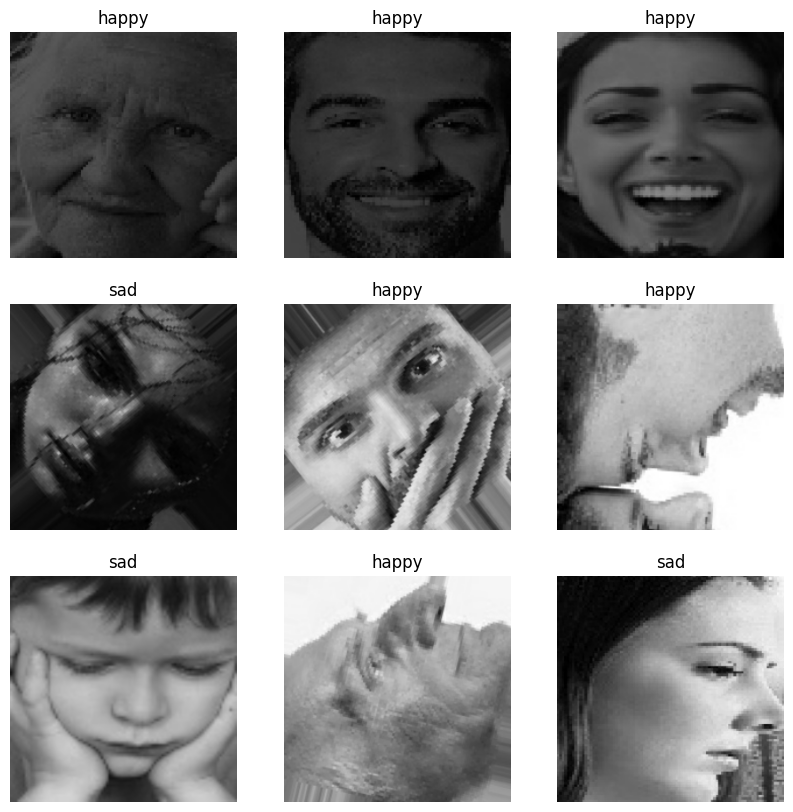

In [27]:
import matplotlib.pyplot as plt
for img, label in train_data.take(1):
  plt.figure(figsize=(10,10))
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(img[i].numpy().astype('uint8'))
    plt.title(CLASS_NAMES[label[i].numpy().argmax()])
    plt.axis('off')

####preparing dataset

In [35]:
train_data=(
    train_data
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [36]:
val_data=(
    val_data
    .shuffle(1000)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

####resize and rescaling

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing,Rescaling

In [39]:
resize_and_rescale_layers=tf.keras.Sequential([
    Resizing(CONFIGURATIONS['IMAGE_SIZE'],CONFIGURATIONS['IMAGE_SIZE']),
    Rescaling(1./255)
])

###modeling

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

In [51]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_and_rescale_layers,

    Conv2D(filters = CONFIGURATIONS["N_FILTERS"] , kernel_size = CONFIGURATIONS["KERNEL_SIZE"], strides = CONFIGURATIONS["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATIONS["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATIONS["POOL_SIZE"], strides= CONFIGURATIONS["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATIONS["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATIONS["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATIONS["KERNEL_SIZE"], strides=CONFIGURATIONS["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATIONS["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATIONS["POOL_SIZE"], strides= CONFIGURATIONS["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATIONS["N_DENSE_UNITS_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATIONS["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATIONS["DROPOUT_RATE"]),

    Dense( CONFIGURATIONS['N_DENSE_UNITS_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATIONS["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATIONS["N_CLASSES"], activation = "softmax"),

])

In [52]:
lenet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [53]:
metrics =[CategoricalAccuracy(name='Accuracy'),TopKCategoricalAccuracy(k=2,name='Top-2-Accuracy')]

In [55]:
lenet_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=CONFIGURATIONS['LEARNING_RATE']),
    metrics=metrics
)

In [56]:
history=lenet_model.fit(
    train_data,
    epochs=CONFIGURATIONS['N_EPOCHS'],
    validation_data=val_data,
    verbose=1
)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 34s 77ms/step - Accuracy: 0.4987 - Top-2-Accuracy: 0.7861 - loss: 1.1296 - val_Accuracy: 0.4939 - val_Top-2-Accuracy: 0.7950 - val_loss: 1.0233
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - Accuracy: 0.7408 - Top-2-Accuracy: 0.9203 - loss: 0.6331 - val_Accuracy: 0.6023 - val_Top-2-Accuracy: 0.8573 - val_loss: 0.9394
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - Accuracy: 0.8723 - Top-2-Accuracy: 0.9715 - loss: 0.3609 - val_Accuracy: 0.6475 - val_Top-2-Accuracy: 0.8911 - val_loss: 0.8482
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - Accuracy: 0.9327 - Top-2-Accuracy: 0.9860 - loss: 0.2095 - val_Accuracy: 0.7226 - val_Top-2-Accuracy: 0.9008 - val_loss: 0.8451
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - Accuracy: 0.9381 - Top-2-Accuracy: 0.9907 - loss: 0.1801 - val_Accuracy: 0.6589 - val_Top-2-Accuracy: 0.8635 - val_loss: 1.1955
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - Accuracy: 0.9561 - Top-2

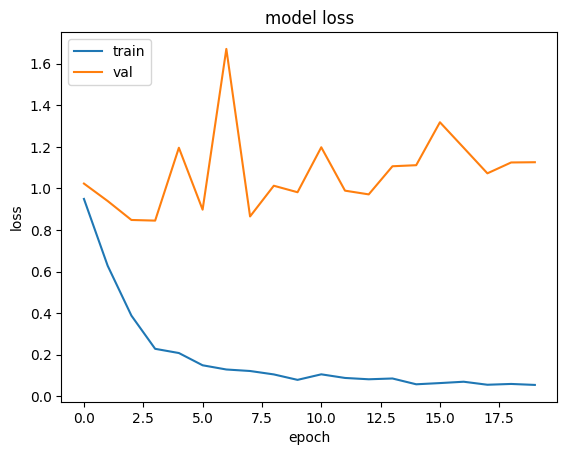

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

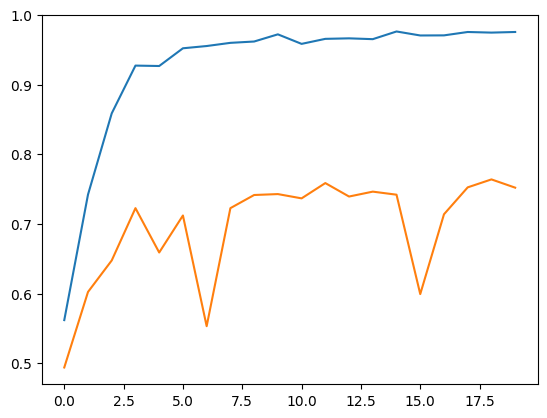

In [58]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt

In [60]:
lenet_model. evaluate(val_data)

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - Accuracy: 0.7478 - Top-2-Accuracy: 0.9054 - loss: 1.1028


[1.125925064086914, 0.751975417137146, 0.9056189656257629]

###testing

In [61]:
import cv2

In [62]:
test_img=cv2.imread('/content/Data/Emotions Dataset/test/happy/111073.jpg')

array([[[ 19,  19,  19],
        [ 12,  12,  12],
        [  9,   9,   9],
        ...,
        [222, 222, 222],
        [223, 223, 223],
        [223, 223, 223]],

       [[ 25,  25,  25],
        [ 18,  18,  18],
        [ 15,  15,  15],
        ...,
        [223, 223, 223],
        [223, 223, 223],
        [223, 223, 223]],

       [[ 78,  78,  78],
        [ 75,  75,  75],
        [ 29,  29,  29],
        ...,
        [223, 223, 223],
        [223, 223, 223],
        [223, 223, 223]],

       ...,

       [[241, 241, 241],
        [243, 243, 243],
        [245, 245, 245],
        ...,
        [126, 126, 126],
        [115, 115, 115],
        [122, 122, 122]],

       [[221, 221, 221],
        [243, 243, 243],
        [243, 243, 243],
        ...,
        [128, 128, 128],
        [134, 134, 134],
        [132, 132, 132]],

       [[222, 222, 222],
        [243, 243, 243],
        [244, 244, 244],
        ...,
        [137, 137, 137],
        [141, 141, 141],
        [141, 141, 141]]], dtype=uint8)
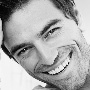

In [63]:
test_img

In [65]:
im = tf. constant(test_img, dtype = tf.float32)
im = tf. expand_dims (im, axis = 0)
print(CLASS_NAMES[tf.argmax(lenet_model (im), axis = -1).numpy()[0]])

happy


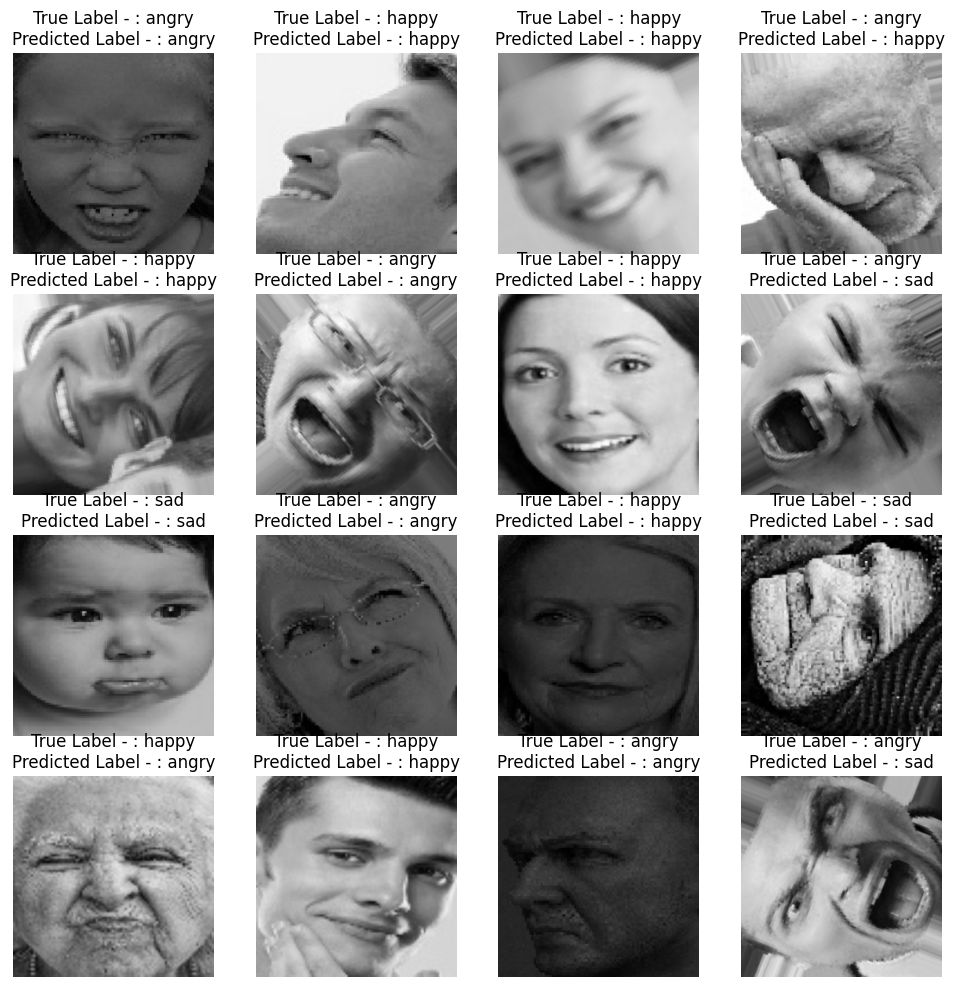

In [70]:
im = tf. constant(test_img, dtype = tf.float32)
im = tf. expand_dims (im, axis = 0)

plt.figure(figsize=(12, 12))

for images, labels in val_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255.)

        plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis=-1).numpy()] +
                  "\n" + "Predicted Label - : " +
                  CLASS_NAMES[int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis=0)), axis=-1).numpy()[0])])
        plt.axis("off")

In [71]:
predicted = []
labels = []
for im, label in val_data:
    predicted. append (lenet_model (im))
    labels. append (label.numpy())

In [72]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

[[301  93 115]
 [ 38 837 120]
 [ 59 129 554]]


Text(0.5, 58.7222222222222, 'Predicted')

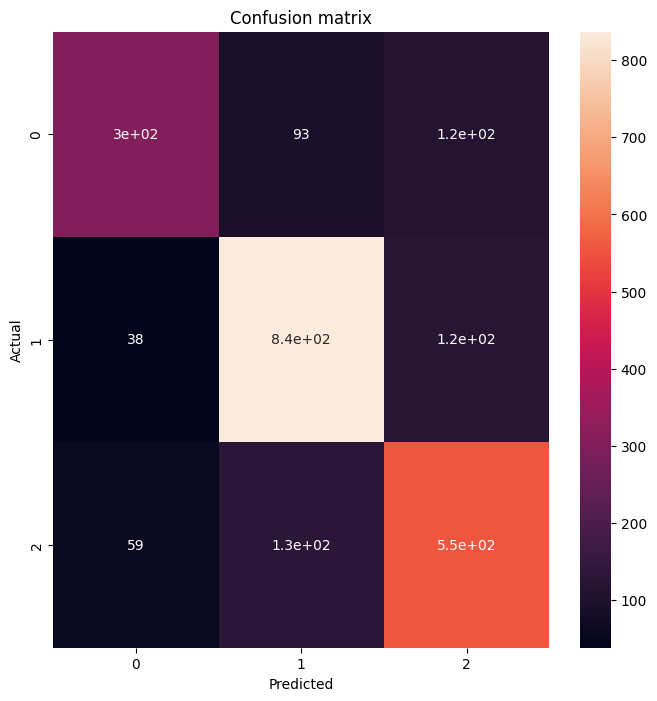

In [77]:
pred = np.concatenate([np.argmax(seq, axis=-1) for seq in predicted[:-1]])
lab = np.concatenate([np.argmax(seq, axis=-1) for seq in labels[:-1]])

cm = confusion_matrix(lab, pred)
print ( cm)
plt.figure(figsize=(8,8))
sns.heatmap (cm, annot=True,)
plt.title( 'Confusion matrix' )
plt.ylabel( 'Actual')
plt.xlabel ( 'Predicted')